In [528]:
import random
from functools import reduce
from collections import namedtuple
from queue import PriorityQueue, SimpleQueue, LifoQueue
from copy import copy, deepcopy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [529]:
PROBLEM_SIZE = 1_000
NUM_SETS = 5_000
SETS = tuple(np.array([random.random() < 0.3 for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))
State = namedtuple('State', ['taken', 'not_taken'])

In [530]:
def fitness1(state):
    cost = sum(state)
    valid = np.all(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

def fitness3(state):
    return sum(state)

fitness = fitness3

In [531]:
def tweak(state):
    new_state = copy(state)
    index = random.randint(0, PROBLEM_SIZE - 1)
    new_state[index] = not new_state[index]
    return new_state

## Single-State Methods

They are used to find local best solutions.

### General procedure
- **Initialization**: choose a starting candidate solution
- **Evaluation**: evaluate the quality of the current solution using the `objective or fitness_function`
- **Modification**: `tweak` the current solution to obtain a new candidate solution (modify it a little bit)
- **Selection**: choose which candidate solution to keep
- **Termination**: stop when a termination criterion is met
  - Maximum number of iterations
  - Maximum number of evaluations
  - Wall-clock time
  - Quality threshold

#### Tweaking

Optimization algorithms define specific `tweak operators` tailored to the problem. These operators dictate how to modify solutions, such as:
- swapping elements
- adjusting values
- applying random noise

🔎 **Exploitation**: make small adjustments to the current solution to improve it
1. *Adjust the modification procedure*, usually making a `small tweak` to the current solution
2. *Use a larger sample*, exploring a larger region of the search space (`neighborhood`) at each step
  
🗺️ **Exploration**: make large adjustments to explore a different region of the search space

1. *Adjust the modification procedure*, occasionally making a `big tweak` to explore a different region of the search space
2. *Adjust the selection procedure*, occasionally accept a `worse solution` to avoid getting stuck in a local optimum
3. *Jump to sth new*, restarting the algorithm from a `different random starting point` to explore a different region of the search space

## Hill-Climbing

* `Random Mutation HC`: It just iteratively test new candidate solutions in the region of the current candidate, and adopt the new ones if they're better.
* `Steepest ascent HC`: it generates multiple "tweaks" to a candidate solution simultaneously, and then it selects the best-performing one for adoption.
* `Random-restart HC`: In order to avoid getting stuck in a local optimum, we can restart the algorithm from a different random starting point. Note that we're just increasing the probability of finding the global optimum, but we're not guaranteed to find it.

In [532]:
def random_mutation_hc(problem, max_iterations):
    number_iterations = 0

    # Loop until we reach the maximum number of iterations
    for _ in range(max_iterations):
        number_iterations += 1
        actual_state = deepcopy(problem)
        next_state = tweak(problem)

        if(fitness(next_state) > fitness(actual_state)):
            problem = next_state

            # If we have reached a satisfactory solution, stop
            if(fitness(problem) == PROBLEM_SIZE):
                break

    return problem, number_iterations

def steepest_ascend_hc(problem, max_iterations, neighbours_size):
    number_iterations = 0

    # Loop until we reach the maximum number of iterations
    for _ in range(max_iterations):
        number_iterations += 1
        actual_state = deepcopy(problem)
        
        # Get all the neighbours
        neighbours = [tweak(problem) for _ in range(neighbours_size)]
        best_neighbour = max(neighbours, key=fitness)
        if(fitness(best_neighbour) > fitness(actual_state)):
            problem = best_neighbour

            # If we have reached a satisfactory solution, stop
            if(fitness(problem) == PROBLEM_SIZE):
                break

    return problem, number_iterations

def random_restart_hc(max_iterations, restarts):
    best_solution = None
    number_of_restarts = 0

    # Loop until we reach the maximum number or restarts
    for _ in range(restarts):
        problem = np.array([random.choice([True, False, False, False, False]) for _ in range(PROBLEM_SIZE)])
        number_of_restarts += 1
        problem, _ = random_mutation_hc(problem, max_iterations)

        if(best_solution is None or fitness(problem) > fitness(best_solution)):
            best_solution = problem

        # If we have reached a satisfactory solution, stop
        if(fitness(problem) == PROBLEM_SIZE):
            break

    return best_solution, number_of_restarts

In [533]:
problem = np.array([False for _ in range(PROBLEM_SIZE)])
solved_problem_rm, iterations_rm = random_mutation_hc(problem, 10000)
solved_problem_sa, iterations_sa = steepest_ascend_hc(problem, 10000, 15)
solved_problem_rr, iterations_rr = random_restart_hc(6500, 10)

print("####Random Mutation Hill Climbing####")
print("original problem fitness:\t", fitness(problem))
print("solved problem fitness:\t\t", fitness(solved_problem_rm))
print("iterations:\t\t\t", iterations_rm)
print("---------------------------------------\n")

print("####Steepest Ascend Hill Climbing####")
print("original problem fitness:\t", fitness(problem))
print("solved problem fitness:\t\t", fitness(solved_problem_sa))
print("iterations:\t\t\t", iterations_sa)
print("---------------------------------------\n")

print("####Random Restart Hill Climbing####")
print("original problem fitness:\t", fitness(problem))
print("solved problem fitness:\t\t", fitness(solved_problem_rr))
print("restarts:\t\t\t", iterations_rr)
print("---------------------------------------\n")

####Random Mutation Hill Climbing####
original problem fitness:	 0
solved problem fitness:		 1000
iterations:			 8101
---------------------------------------

####Steepest Ascend Hill Climbing####
original problem fitness:	 0
solved problem fitness:		 1000
iterations:			 1374
---------------------------------------

####Random Restart Hill Climbing####
original problem fitness:	 0
solved problem fitness:		 1000
restarts:			 4
---------------------------------------



### Simulated-Annealing

This technique is based on performing exploration, and then exploitation, based on an hyperparameter, the temperature, that allows to accept a worse candidate solution with a certain probability.
This is useful to escape from local minima

The probability of accepting a new candidate solution is defined by the `Boltzmann distribution`:
- $S$ = current solution
- $R$ = new candidate solution
- $t$ = current temperature
- $c$ = cooling rate $\in [0,1]$ that defines how fast the temperature decreases

$P(R|S,t) = e^{\frac{Quality(R)-Quality(S)}{t}}$

In [534]:
def simulated_annealing(problem, temperature, cooling_rate, max_iterations):
    number_iterations = 0

    # Loop until we reach the maximum number of iterations
    for _ in range(max_iterations):
        number_iterations += 1
        actual_state = deepcopy(problem)
        next_state = tweak(problem)

        if(fitness(next_state) > fitness(actual_state)):
            problem = next_state

            # If we have reached a satisfactory solution, stop
            if(fitness(problem) == PROBLEM_SIZE):
                break
        else:
            # Calculate the probability of accepting the worse solution
            probability = np.exp((fitness(next_state) - fitness(actual_state)) / temperature)

            if(random.random() < probability):
                problem = next_state

        # Cool the temperature
        temperature *= cooling_rate

        # If the temperature is too low, stop
        if(temperature < 1e-15):
            break

    return problem, number_iterations


In [535]:
solved_problem_ann, iterations_ann = simulated_annealing(problem, 100, 0.999, 10000)

print("####Simulated Annealing####")
print("original problem fitness:\t", fitness(problem))
print("solved problem fitness:\t\t", fitness(solved_problem_ann))
print("iterations:\t\t\t", iterations_ann)
print("---------------------------------------\n")


####Simulated Annealing####
original problem fitness:	 0
solved problem fitness:		 996
iterations:			 10000
---------------------------------------



### Tabu search
Tabu search is a popular metaheuristic that guides a local search procedure to explore the search space beyond the local optimum.

> 🙅🏻‍♀️ It is based on the idea of `forbidding` the algorithm to visit the same state twice, i.e. it keeps track of the visited states in a `tabu list` and avoids them for a certain number of iterations.

It is particularly effective in solving *combinatorial optimization problems*, where the goal is to find the best solution from a finite set of possibilities. But really only works well when the search space is discrete and finite.
- ⚠️ If the search space is continuous or infinite, only in truly and exceptionally rare cases will the algorithm ever visit the same state twice! In this case, we should check if the current solution is *sufficiently similar* to a previously visited one, and then decide whether to forbid it or not.

In [536]:
def tabu_search(problem, max_iterations):
    number_iterations = 0
    tabu_list = []

    # Loop until we reach the maximum number of iterations
    for _ in range(max_iterations):
        number_iterations += 1
        actual_state = deepcopy(problem)
        next_state = tweak(problem)

        if(fitness(next_state) > fitness(actual_state)):
            problem = next_state

            # If we have reached a satisfactory solution, stop
            if(fitness(problem) == PROBLEM_SIZE):
                break
        else:
            # If the next state is in the tabu list, skip it
            if(fitness(next_state) in tabu_list):
                continue

            problem = next_state

        # Add the actual state to the tabu list
        tabu_list.append(fitness(actual_state))
    return problem, number_iterations

In [537]:
solved_problem_tabu, iterations_tabu = tabu_search(problem, 10000)

print("####Tabu Search####")
print("original problem fitness:\t", fitness(problem))
print("solved problem fitness:\t\t", fitness(solved_problem_tabu))
print("iterations:\t\t\t", iterations_tabu)
print("---------------------------------------\n")

####Tabu Search####
original problem fitness:	 0
solved problem fitness:		 999
iterations:			 10000
---------------------------------------



## Iterated local search
Iterated local search is a metaheuristic that combines a local search procedure with a perturbation mechanism to escape local optima, and it is essentially a smarter version of random-restart hill climbing.

> It tries to stochasticly hill climb in the space of local optima. To do so, it uses a `home base` solution, which is the best solution found so far, and a `perturbation operator` perform a *just large enough jump* to escape this local optimum and land in a different region of the search space. ⛰️<--🏃🏻‍♂️--🏡

1. Hill climbing is used iteratively for a maximum number of iterations to find a local optimum 
2. If the new local optimum is better than the current home base, it becomes the new home base
3. The perturbation operator is designed to be substantial enough to likely jump to a new region of the solution space

### 📈 Himmelblau's function
In mathematical optimization, Himmelblau's function is a multi-modal function 
used to test the performance of optimization algorithms.

$$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$

- `Input domain`
  - This function is usually evaluated on the square $x,y \in [-4,4]$
- `Local maximum`
  - $f(-0.270845, -0.923039) = 181.617$
- `Global minima`
  - $f(3.0,2.0) = 0.0$
  - $f(-2.805118,3.131312) = 0.0$
  - $f(-3.779310,-3.283186) = 0.0$
  - $f(3.584428,-1.848126) = 0.0$

> ⚠️ Since in computer science we usually want to maximize our objective function, I will use the negative of Himmelblau's function for its landscape representation.

In [580]:
def himmelblau(x, y):
    return -((x**2 + y - 11)**2 + (x + y**2 - 7)**2)

def tweak_himmelblau(x, y):
    new_x = x + random.uniform(-0.1, 0.1)
    new_y = y + random.uniform(-0.1, 0.1)

    # Make sure the new values are in the range [-4, 4]
    new_x = max(min(new_x, 4), -4)
    new_y = max(min(new_y, 4), -4)

    return new_x, new_y

def home_base_tweak_himmelblau(x, y):
    new_x = x + random.uniform(-0.5, 0.5)
    new_y = y + random.uniform(-0.5, 0.5)

    # Make sure the new values are in the range [-4, 4]
    new_x = max(min(new_x, 4), -4)
    new_y = max(min(new_y, 4), -4)
    
    return new_x, new_y

def visualize_population(fitness_values, population=None, parents=None, best_individual=None):
    x = np.arange(-4, 4, 0.1)
    y = np.arange(-5, 4, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)

    fig = plt.figure('himmelblau')
    fig.suptitle('Population Distribution')
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap=plt.cm.viridis, levels=np.linspace(np.min(Z), 9, 27))
    ax.contour(X, Y, Z, colors='white', alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if population is not None:
        population_x = [ind[0] for ind in population]
        population_y = [ind[1] for ind in population]
        ax.scatter(population_x, population_y, color='orange', marker='o', label='Population', s=20)
    
    if parents is not None:
        parents_x = [ind[0] for ind in parents]
        parents_y = [ind[1] for ind in parents]
        ax.scatter(parents_x, parents_y, color='red', marker='o', label='Parents', s=20)
    
    if best_individual is not None:
        # use a star marker to denote the best individual
        ax.scatter(best_individual[0], best_individual[1], color='white', marker='*', 
            label='All-time best\nf({:.4f}, {:.4f}) = {:.4f}'.format(best_individual[0], best_individual[1], himmelblau(best_individual[0], best_individual[1])),
            s=100, edgecolors='black', linewidths=0.5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)
    
    info = []
    info.append('Global maxima:')
    info.append('1) f(3.0,2.0) = 0.0')
    info.append('2) f(-2.805118,3.131312) = 0.0')
    info.append('3) f(-3.779310,-3.283186) = 0.0')
    info.append('4) f(3.584428,-1.848126) = 0.0')

    plt.figtext(0.95, 0.45, '\n'.join(info), fontsize=10, va='bottom', ha='left', linespacing=1.5)
    plt.show()

    plt.figure()

    # Plotta i valori di fitness_values
    plt.plot(fitness_values, label='Fitness')

    # Aggiungi titoli e etichette
    plt.title('Valori di fitness nel tempo')
    plt.xlabel('Iterazione')
    plt.ylabel('Fitness')

    # Mostra il grafico
    plt.show()


In [539]:
def rastrigin(x, A=10):
    """NumPy Rastrigin test function"""
    if x.ndim == 1:
        return -np.sum(A - A * np.cos(2 * np.pi * x) + x**2)
    else:
        return -np.sum(A - A * np.cos(2 * np.pi * x) + x**2, axis=1)

def rastrigin_nico(x, y, A=10):
    A = 10
    return -(2 * A + (x**2 - A * np.cos(2 * np.pi * x)) + (y**2 - A * np.cos(2 * np.pi * y)))

In [540]:
x = np.linspace(-5.12, 5.12, 100)
y = np.linspace(-5.12, 5.12, 100)

X, Y = np.meshgrid(x, y)
Z = rastrigin_nico(X, Y)

In [577]:
def plot_rastrigin(x_sol, y_sol, fitness_values_rastr):   
    plt.figure()
    plt.imshow(Z, extent=[-5.12, 5.12, -5.12, 5.12], origin='lower', cmap='viridis')
    plt.colorbar(label='Valore di Rastrigin')
    plt.plot(x_sol, y_sol, 'ro')  # Plotta la soluzione come un punto rosso
    plt.title('Funzione di Rastrigin')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    plt.figure()

    # Plotta i valori di fitness_values
    plt.plot(fitness_values_rastr, label='Fitness')

    # Aggiungi titoli e etichette
    plt.title('Valori di fitness nel tempo')
    plt.xlabel('Iterazione')
    plt.ylabel('Fitness')

    # Mostra il grafico
    plt.show()

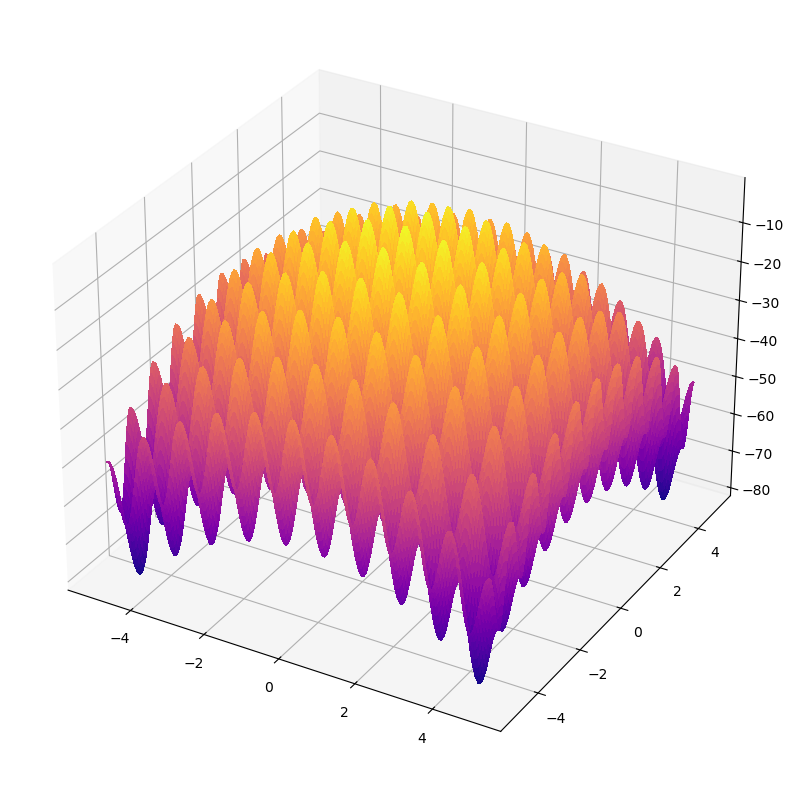

In [542]:
N_POINTS = 200
r = np.linspace(-5, 5, N_POINTS)

x = np.array(np.meshgrid(r, r)).T.reshape(-1, 2)
z = rastrigin(x).reshape(N_POINTS, N_POINTS)
plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(
    *np.meshgrid(r, r),
    z,
    rstride=1,
    cstride=1,
    cmap=cm.plasma,
    linewidth=0,
    antialiased=False,
)
None

In [543]:
def tweak_rastrigin(x, y):
    new_x = x + random.uniform(-0.075, 0.075)
    new_y = y + random.uniform(-0.1, 0.1)

    # Make sure the new values are in the range [-4, 4]
    new_x = max(min(new_x, 5.12), -5.12)
    new_y = max(min(new_y, 5.12), -5.12)

    return new_x, new_y

def home_base_tweak_rastrigin(x, y):
    new_x = x + random.uniform(-1, 1)
    new_y = y + random.uniform(-1, 1)

    # Make sure the new values are in the range [-4, 4]
    new_x = max(min(new_x, 5.12), -5.12)
    new_y = max(min(new_y, 5.12), -5.12)

    return new_x, new_y

In [579]:
def iterated_local_search(max_iterations):
    fitness_values = []
    number_iterations = 0
    actual_x = random.uniform(-4.0, 4.0)
    actual_y = random.uniform(-4.0, 4.0)
    actual_fitness = himmelblau(actual_x, actual_y)

    best_x = actual_x
    best_y = actual_y
    best_fitness = actual_fitness
    fitness_values.append(best_fitness)
    
    # Loop until we reach the maximum number of iterations
    for _ in range(max_iterations):
        number_iterations += 1

        # Run the hill climbing algorithm for a certain amount of time
        time = np.random.choice([10, 20, 30, 40, 50])
        while time > 0:
            time -= 1
            next_x, next_y = tweak_himmelblau(actual_x, actual_y)
            next_fitness = himmelblau(next_x, next_y)

            # if the next state is better, update the actual state
            if next_fitness > actual_fitness:
                actual_x = next_x
                actual_y = next_y
                actual_fitness = next_fitness
            
            # if we have reached a satisfactory solution, stop
            if actual_fitness == 0 - 1e-15:
                return actual_x, actual_y, actual_fitness

        # if the actual state is better than the best state, update the best state
        if actual_fitness > best_fitness:
            best_x = actual_x
            best_y = actual_y
            best_fitness = actual_fitness
            fitness_values.append(best_fitness)

        # if we have reached a satisfactory solution, stop
        if best_fitness == 0 - 1e-15:
            return best_x, best_y, best_fitness, number_iterations, fitness_values
        
        # Generate a new solution by tweaking the home base
        actual_x, actual_y = home_base_tweak_himmelblau(best_x, best_y)
        actual_fitness = himmelblau(actual_x, actual_y)

    return best_x, best_y, best_fitness, number_iterations, fitness_values


In [566]:
def iterated_local_search_rastr(max_iterations):
    fitness_values = []
    number_iterations = 0
    actual_x = random.uniform(-5.12, 5.12)
    actual_y = random.uniform(-5.12, 5.12)
    actual_fitness = rastrigin_nico(actual_x, actual_y)

    best_x = actual_x
    best_y = actual_y
    best_fitness = actual_fitness
    fitness_values.append(best_fitness)
    
    
    # Loop until we reach the maximum number of iterations
    for _ in range(max_iterations):
        number_iterations += 1

        # Run the hill climbing algorithm for a certain amount of time
        time = np.random.choice([100, 200, 300, 400, 500])
        while time > 0:
            time -= 1
            next_x, next_y = tweak_rastrigin(actual_x, actual_y)
            next_fitness = rastrigin_nico(next_x, next_y)

            # if the next state is better, update the actual state
            if next_fitness > actual_fitness:
                actual_x = next_x
                actual_y = next_y
                actual_fitness = next_fitness
            
            # if we have reached a satisfactory solution, stop
            if actual_fitness == 0 - 1e-15:
                return actual_x, actual_y, actual_fitness

        # if the actual state is better than the best state, update the best state
        if actual_fitness > best_fitness:
            best_x = actual_x
            best_y = actual_y
            best_fitness = actual_fitness
            fitness_values.append(best_fitness)

        # if we have reached a satisfactory solution, stop
        if best_fitness == 0 - 1e-15:
            return best_x, best_y, best_fitness, number_iterations, fitness_values
        
        # Generate a new solution by tweaking the home base
        actual_x, actual_y = home_base_tweak_rastrigin(best_x, best_y)
        actual_fitness = rastrigin_nico(actual_x, actual_y)

    return best_x, best_y, best_fitness, number_iterations, fitness_values

#### Iterated Local Search (himmelblau) ####
x:		 -2.794033751469603
y:		 3.1178442389298615
fitness:	 -0.011045795978168581
iterations:	 10
---------------------------------------



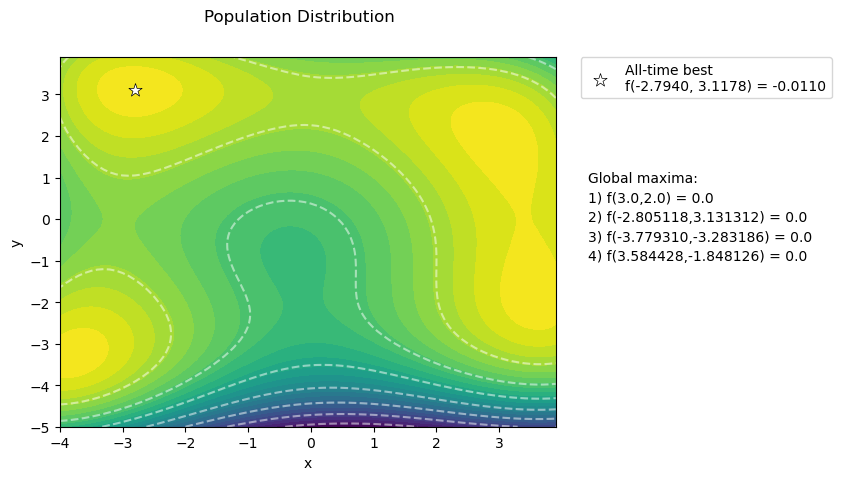

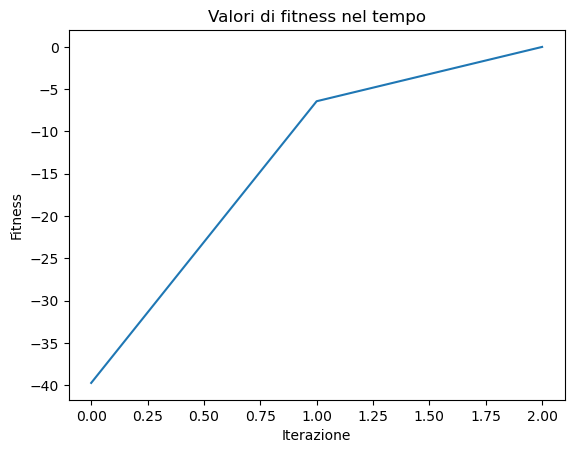

#### Iterated Local Search (Rastrigin) ####
x:		 0.00015603730789229275
y:		 -0.000330485021675736
fitness:	 -2.6498824498233375e-05
iterations:	 1000
---------------------------------------



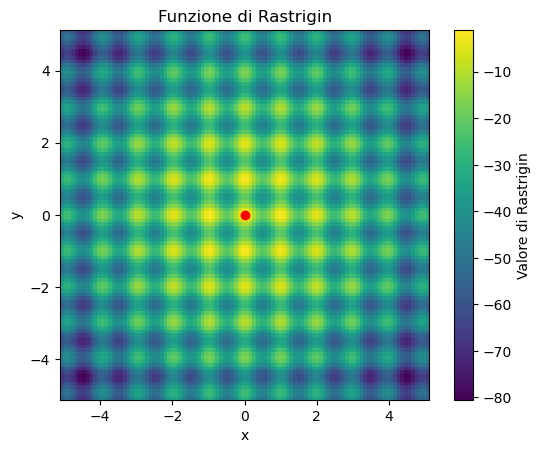

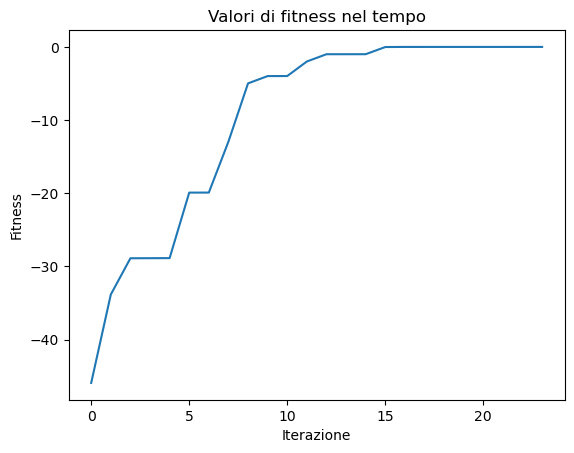

In [581]:
x_sol, y_sol, fitness_sol, iterations_himmel, fitness_values_himmel = iterated_local_search(10)

print("#### Iterated Local Search (himmelblau) ####")
print("x:\t\t", x_sol)
print("y:\t\t", y_sol)
print("fitness:\t", fitness_sol)
print("iterations:\t", iterations_himmel)
print("---------------------------------------\n")
visualize_population(fitness_values_himmel, best_individual=(x_sol, y_sol))


x_sol, y_sol, fitness_sol, iterations_rastr, fitness_values_rastr = iterated_local_search_rastr(1000)

print("#### Iterated Local Search (Rastrigin) ####")
print("x:\t\t", x_sol)
print("y:\t\t", y_sol)
print("fitness:\t", fitness_sol)
print("iterations:\t", iterations_rastr)
print("---------------------------------------\n")
plot_rastrigin(x_sol, y_sol, fitness_values_rastr)